In [39]:
import sys
sys.path.append("../../")
from simulation_classes.drones import Drones
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


続いてドローンの初期化を行う。
複数台の巡行をシミュレートする。

N: ドローン台数

擾乱の与え方
1. 先頭のみ突風で速度Down
2. 突風で先頭のN台が同タイミングで失速
3. 上空のある空域にボトルネックを入れる
4. 速度調整の命令のLatency

In [40]:
N = 3
T = 1000
a = 0.7
delta_t = 0.1
initial_delta_x = 0.1
legal_speed= 1.7
wind_speed = 1.0

condition = "leader_stall" 
# condition = "simultaneous_stall"
# condition = "usual"

drone_list = []

# ここで一気に初期化
for i in range(N):
  xcor = initial_delta_x * (N -i)
  v = 0.1 if i==0 else 0
  drone = Drones(xcor, 0, v, a, 1, legal_speed)
  drone_list.append(drone)

In [41]:
# ここからシミュレーション開始
for i in range(T):

  # 擾乱を加える
  if condition == "simultaneous_stall":
    if i%400 == 0:
      for idx, drone_i in enumerate(drone_list):
        if idx < 10:
          next_speed = max(drone_i.v_x - wind_speed, 0)
          drone_i.force_velocity_change(next_speed)

  if condition == "leader_stall":
    if i%400 == 0:
      leader = drone_list[0]
      next_speed = max(leader.v_x - wind_speed, 0)
      leader.force_velocity_change(next_speed)
    
  for idx,drone_i in enumerate(drone_list):
    if idx == 0:
      leader = drone_list[idx]
      leader.leader_update(delta_t)
      leader.record()
    else:
      follower = drone_list[idx]
      delta_x = drone_list[idx-1].xcor - follower.xcor
      if (delta_x) < 0:
        print(f"idx={idx}")
        print("先行車のx座標",drone_list[idx-1].xcor)
        print("followerのx座標",drone_list[idx].xcor)
        raise ValueError(f"追い抜きが発生しました")

      follower.update(delta_t,delta_x )
      follower.record()


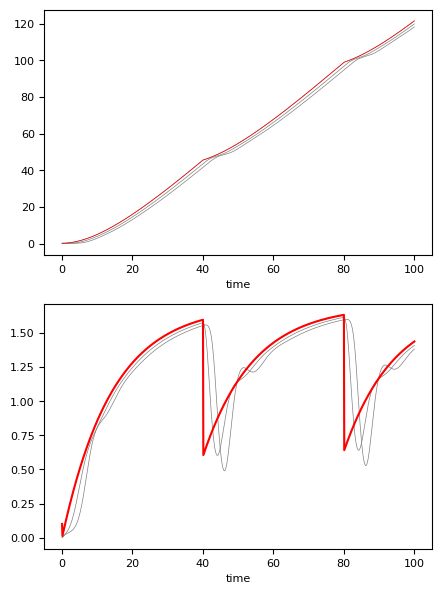

In [42]:
t = np.linspace(0,delta_t*(T+1), T+1)

plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
for drone in drone_list:
    plt.plot(t,np.array(drone.xcorList), color="gray", linewidth=0.5)
plt.plot(t,np.array(drone_list[0].xcorList), color="red",linewidth=0.5)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("time", fontsize=8)

plt.subplot(2,1,2)
for drone in drone_list:
    plt.plot(t,np.array(drone.v_xList), color="gray", linewidth=0.5)
plt.plot(t,np.array(drone_list[0].v_xList), color="red")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("time", fontsize=8)

plt.savefig(f"../../result/condition={condition}_a={a}_N={N}_MaxSpeed={legal_speed}_windSpeed={wind_speed}_leaderUpdateChanged.png")

In [43]:
#vars(drone_list[1])
# print(drone_list[1].v_xList)

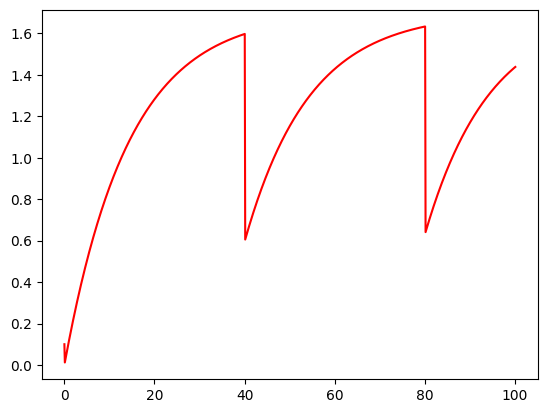

In [44]:
T = len(drone_list[0].v_xList)
t = np.linspace(0,delta_t*(T), T)
plt.plot(t,np.array(drone_list[0].v_xList), color="red")